In [61]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
import json
from utils.utils import get_consecutives

import fastf1
import fastf1.plotting

fastf1.Cache.enable_cache('./data')  

In [62]:
YEAR = 2023
RS = 12122023

## Get all laps

In [63]:
def load_all_races(year):
    '''
    load all races for the chosen year. excludes testing
    '''
    
    schedule= fastf1.get_event_schedule(year)[1:]
    allRaces = {}
    for i in schedule['EventName']:
        
        race = fastf1.get_session(year, i, 'R')
        
        race.load(laps=True, telemetry=False, weather=True,messages=False)
        try:
            allRaces[i] = race.laps
        except Exception as e:
            print(f"Failed to load {i}",e)
            pass
    return allRaces 

allRaces = load_all_races(YEAR)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for se

## Full laps organized



In [64]:
drivers = {}

for k,r in allRaces.items():
    r['LapTime'] = r['LapTime']
    r['NormLapTime'] = r.LapTime/r.LapTime.min()
    for d in r.Driver.unique():
        try:
            drivers[d] = pd.concat([drivers[d], r[r.Driver == d]])
        except Exception as e:
            drivers[d] = r[r.Driver == d]
            


## Methodology

In [85]:
allDrivers = pd.DataFrame(columns=drivers.keys())
for k,v in drivers.items():
    allDrivers[k] = pd.Series(v.LapTime.values)

allDriversNorm = pd.DataFrame(columns=drivers.keys())
at3 = pd.Series()
for k,v in drivers.items():
    allDriversNorm[k] = pd.Series(v.NormLapTime.values)
    if k in ['RIC','LAW','DEV']:
        at3 = at3.append(pd.Series(v.NormLapTime.values))
allDriversNorm['AT3'] = pd.Series(at3.values)

drivers['VER'].sort_values(by='NormLapTime').head(5)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,NormLapTime
49,0 days 02:24:11.176000,VER,1,0 days 00:01:31.906000,50.0,2.0,NaT,NaT,0 days 00:00:33.543000,0 days 00:00:29.045000,...,Red Bull Racing,0 days 02:22:39.270000,NaT,1,2.0,None,,False,True,1.0
44,0 days 02:10:24.630000,VER,1,0 days 00:01:26.993000,45.0,3.0,NaT,NaT,0 days 00:00:17.505000,0 days 00:00:37.714000,...,Red Bull Racing,0 days 02:08:57.637000,NaT,1,1.0,None,,False,True,1.0
55,0 days 02:28:47.407000,VER,1,0 days 00:01:24.319000,56.0,4.0,NaT,NaT,0 days 00:00:30.765000,0 days 00:00:28.669000,...,Red Bull Racing,0 days 02:27:23.088000,NaT,1,1.0,None,,False,True,1.0
55,0 days 02:28:54.554000,VER,1,0 days 00:01:29.708000,56.0,2.0,NaT,NaT,0 days 00:00:30.233000,0 days 00:00:34.098000,...,Red Bull Racing,0 days 02:27:24.846000,NaT,1,1.0,None,,False,True,1.0
60,0 days 02:23:44.568000,VER,1,0 days 00:01:16.330000,61.0,3.0,NaT,NaT,0 days 00:00:22.706000,0 days 00:00:30.589000,...,Red Bull Racing,0 days 02:22:28.238000,NaT,1,1.0,None,,False,True,1.0


Text(0.5, 1.0, 'NOR vs HAM Normalized Absolute Pace')

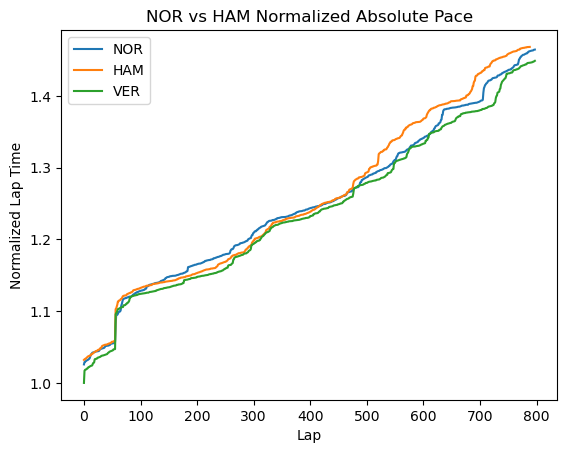

In [77]:
min_time = allDrivers.min().sort_values()[0]
allDrivers_norm = allDrivers.copy()
allDrivers_norm = allDrivers_norm/min_time
# for c in allDrivers.columns:
#     allDrivers_norm[c] = allDrivers_norm[c]/min_time
allDrivers_norm['AT3'] = allDrivers_norm['LAW']

driver1 = 'NOR'
driver2 = 'HAM'
driver3 = 'VER'

ver_norm = allDrivers_norm[allDrivers_norm[driver1] < allDrivers_norm[driver1].quantile(.8)][driver1].sort_values().reset_index(drop=True)

per_norm = allDrivers_norm[allDrivers_norm[driver2] < allDrivers_norm[driver2].quantile(.8)][driver2].sort_values().reset_index(drop=True)

diver3_norm = allDrivers_norm[allDrivers_norm[driver3] < allDrivers_norm[driver3].quantile(.8)][driver3].sort_values().reset_index(drop=True)

norm = pd.DataFrame()
norm[driver1] = ver_norm
norm[driver2] = per_norm
norm[driver3] = diver3_norm

plt = sns.lineplot(data=norm,dashes=False)
plt.set(xlabel='Lap', ylabel='Normalized Lap Time')
plt.set_title(f'{driver1} vs {driver2} Normalized Absolute Pace')

Area between HAM and RUS is 0.2606927363412961


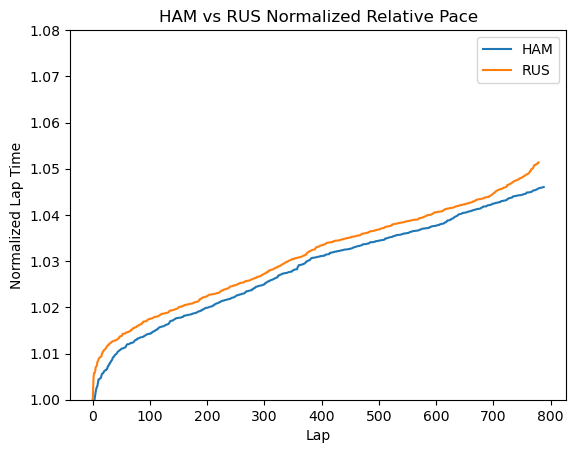

In [104]:


def plot_normalized_drivers(df, driver1='PER', driver2='PER', driver3=None):
    '''
    Plot normalized lap times for 3 drivers
    '''
    driver1_norm = df[df[driver1] < df[driver1].quantile(.8)][driver1].sort_values().reset_index(drop=True)

    driver2_norm = df[df[driver2] < df[driver2].quantile(.8)][driver2].sort_values().reset_index(drop=True)

    norm = pd.DataFrame()
    norm[driver1] = driver1_norm
    norm[driver2] = driver2_norm
    
    if driver3:
        driver3_norm = df[df[driver3] < df[driver3].quantile(.8)][driver3].sort_values().reset_index(drop=True)
        norm[driver3] = driver3_norm

    plt = sns.lineplot(data=norm,dashes=False)
    plt.set(xlabel='Lap', ylabel='Normalized Lap Time')
    plt.set_title(f'{driver1} vs {driver2} Normalized Relative Pace')
    plt.set_ylim(1.0,1.08)
    
    length = min(len(driver1_norm), len(driver2_norm))
    
    area = abs(np.trapz(y=driver1_norm[:length] - driver2_norm[:length]))
    print(f"Area between {driver1} and {driver2} is {area*100/length}")
    
plot_normalized_drivers(allDriversNorm, driver1='HAM', driver2='RUS')


## Attempt to normalize by race 

In [87]:
drivers = {}

for k,r in allRaces.items():
    r['LapTime'] = r['LapTime']
    r['NormLapTime'] = r.LapTime/r.LapTime.min()
    for d in r.Driver.unique():
        drive = r[r.Driver == d]
        drive = drive[drive.NormLapTime < drive.NormLapTime.quantile(.8)].copy()
        
        try:
            drivers[d] = pd.concat([drivers[d], drive])
        except Exception as e:
            drivers[d] = drive
            
allDriversNorm2 = pd.DataFrame(columns=drivers.keys())
for k,v in drivers.items():
    allDriversNorm2[k] = pd.Series(v.NormLapTime.values)


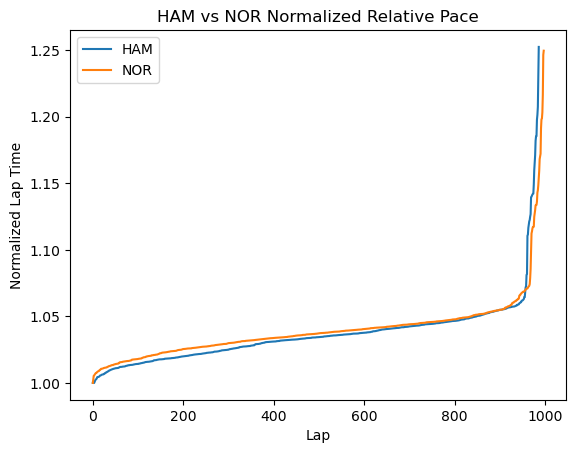

In [88]:


def plot_normalized_drivers_test(df, driver1='PER', driver2='PER', driver3=None):
    '''
    Plot normalized lap times for 3 drivers
    '''
    driver1_norm = df[driver1].sort_values().reset_index(drop=True)

    driver2_norm = df[driver2].sort_values().reset_index(drop=True)

    norm = pd.DataFrame()
    norm[driver1] = driver1_norm
    norm[driver2] = driver2_norm
    
    if driver3:
        driver3_norm = df[df[driver3] < df[driver3].quantile(.8)][driver3].sort_values().reset_index(drop=True)
        norm[driver3] = driver3_norm

    plt = sns.lineplot(data=norm,dashes=False)
    plt.set(xlabel='Lap', ylabel='Normalized Lap Time')
    plt.set_title(f'{driver1} vs {driver2} Normalized Relative Pace')

plot_normalized_drivers_test(allDriversNorm2, driver1='HAM', driver2='NOR')